In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

In [2]:
IMAGE_SIZE = [100,100] # feel free to change depending on dataset

# training config:
epochs = 10
batch_size = 32

#define paths
covid_path = 'dataset/Covid19 Positive/output'
noncovid_path = 'dataset/Covid19 Negative/output'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [3]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(100,100))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')

for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(100,100))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

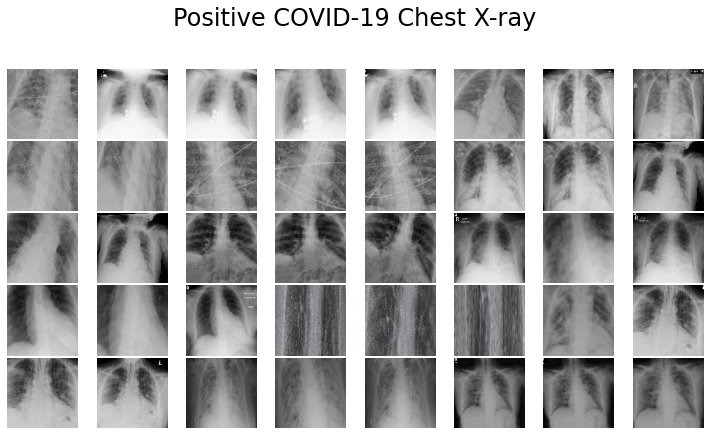

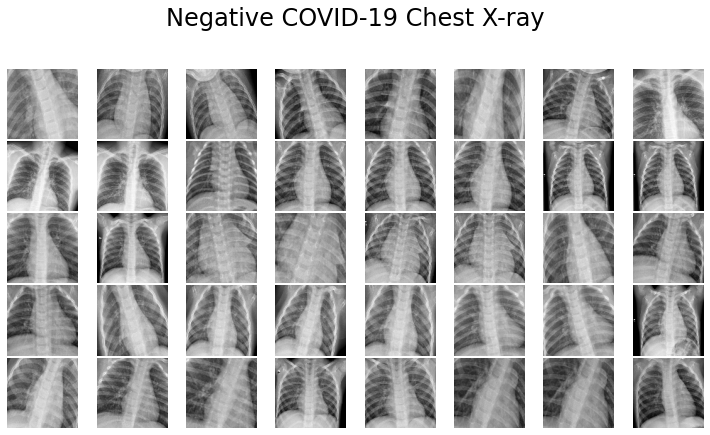

In [4]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [5]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [6]:
print(covid_images.shape)
print(noncovid_images.shape)

(2125, 100, 100, 3)
(2682, 100, 100, 3)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

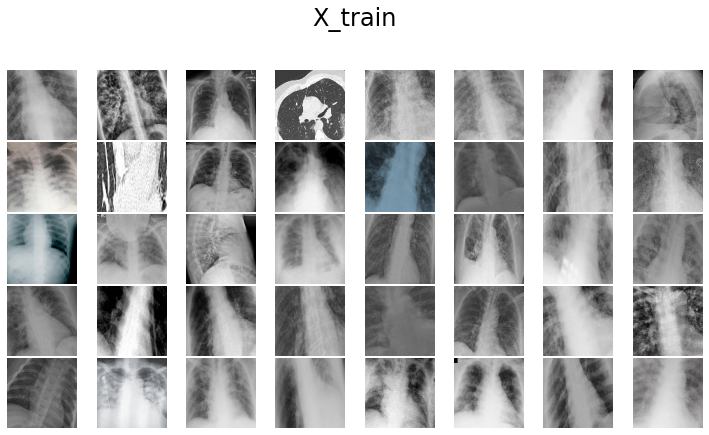

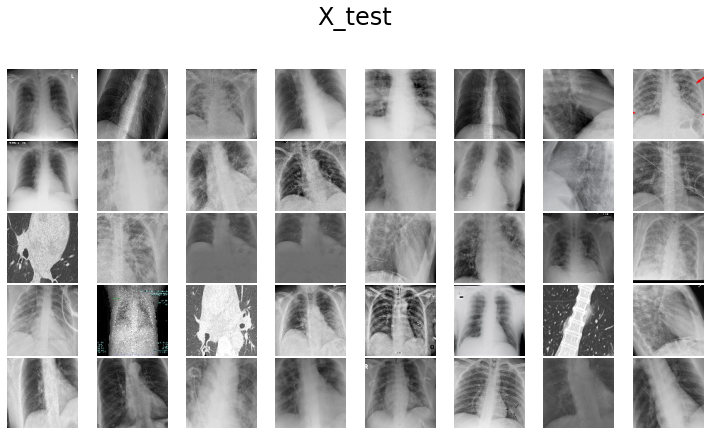

In [8]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D


# model=Sequential()

# model.add(Conv2D(64,(3,3),input_shape=(100,100,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# #The first CNN layer followed by Relu and MaxPooling layers

# model.add(Conv2D(32,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# #The second convolution layer followed by Relu and MaxPooling layers

# model.add(Flatten())
# #Flatten layer to stack the output convolutions from second convolution layer
# model.add(Dropout(0.5))
# model.add(Dense(1000,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64,activation='relu'))
# #Dense layer of 64 neurons
# model.add(Dense(2,activation='softmax'))
# #The Final layer with two outputs for two categories

# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model = Sequential()
model.add(BatchNormalization(input_shape=(100,100,3)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=30,
                    epochs=10)

Epoch 1/10
30/30 [==============================] - 14s 429ms/step - loss: 1.0159 - accuracy: 0.6406 - val_loss: 0.6881 - val_accuracy: 0.6362
Epoch 2/10
30/30 [==============================] - 11s 375ms/step - loss: 0.4857 - accuracy: 0.7688 - val_loss: 0.6509 - val_accuracy: 0.5613
Epoch 3/10
30/30 [==============================] - 11s 373ms/step - loss: 0.4413 - accuracy: 0.8104 - val_loss: 0.6054 - val_accuracy: 0.7599
Epoch 4/10
30/30 [==============================] - 11s 382ms/step - loss: 0.3685 - accuracy: 0.8458 - val_loss: 0.4809 - val_accuracy: 0.8285
Epoch 5/10
30/30 [==============================] - 11s 370ms/step - loss: 0.3482 - accuracy: 0.8650 - val_loss: 0.3984 - val_accuracy: 0.8825
Epoch 6/10
30/30 [==============================] - 11s 372ms/step - loss: 0.3373 - accuracy: 0.8635 - val_loss: 0.3312 - val_accuracy: 0.8721
Epoch 7/10
30/30 [==============================] - 11s 372ms/step - loss: 0.3080 - accuracy: 0.8844 - val_loss: 0.3118 - val_accuracy: 0.8898

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 100, 100, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 average_pooling2d (AverageP  (None, 50, 50, 16)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 flatten (Flatten)           (None, 40000)             0

In [21]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)
print(y_pred_bin)
print("hello")
print(y_test_bin)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

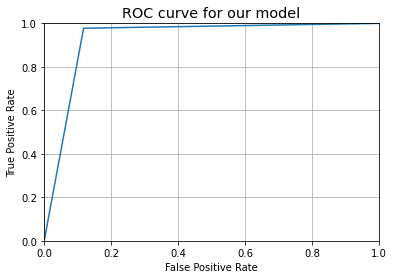

In [15]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


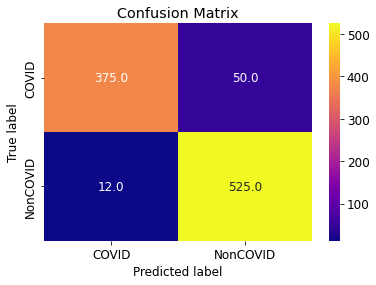

Confusion Matrix with Normalized Values


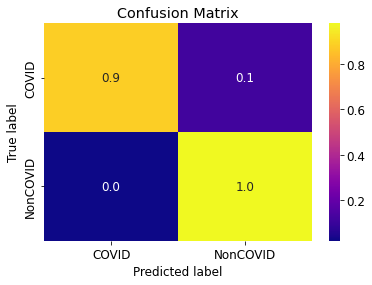

In [16]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',fmt=".1f",annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       425
           1       0.91      0.98      0.94       537

    accuracy                           0.94       962
   macro avg       0.94      0.93      0.93       962
weighted avg       0.94      0.94      0.94       962



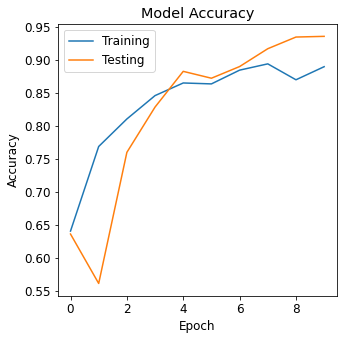

In [18]:
plt.figure(figsize=(5,5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

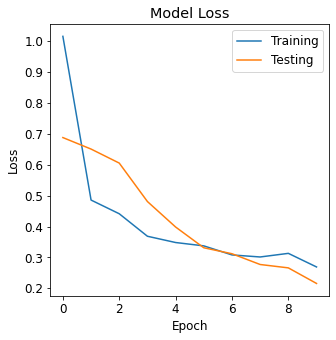

In [19]:
plt.figure(figsize=(5,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()